In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import datetime
import os
import json
import matplotlib.dates as mdates
import seaborn as sns
cm = sns.light_palette("green", as_cmap=True)
from pandas.io.json import json_normalize
from classify_campaigns import classify_campaigns 

import matplotlib.ticker as mtick
import matplotlib.dates as mdates

from google.cloud import bigquery
os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = '/Users/daniel.ryu/.config/gcloud/application_default_credentials.json'
bigquery_client = bigquery.Client(project='apprec-prod')

In [17]:
exchange = pd.read_csv('~/Documents/appreciate/exchanges.csv')
imp_type = pd.read_csv('~/Documents/appreciate/imp_type.csv')
buyer = pd.read_csv('~/Documents/appreciate/buyer.csv')
exchange

exchange_id exchange_name
0             0       Unknown
1             1         Fyber
2             2        Smaato
3             3         MoPub
4             4        Nexage
5             7       Rubicon
6             8        Google
7             9        Axonix
8            10      PubMatic
9            11        MobFox
10           14         Opera
11           18     PubNative
12           21      Appodeal
13           22         Tappx
14           24      AdColony
15           29     SmartyAds
16           30    Chartboost
17           33   NexageVideo
18           36        Vungle
19           37         Unity
20           38         Unity
21           39         Unity
22           41      AppLovin
23           44        InMobi
24           45          SoMo
25           46  MobilityWare
26           47     GothamAds
27           48      Vertical
28           49          Kiip
29           50        MailRu
30           52          Epom
31           53    TripleLift
32           54    IronSource
33           55      StartApp
34           56       Algorix
35           57     RhythmOne
36           58       Etermax
37           59       Samsung
38           60     ByteDance
39           99          Test

In [3]:
end_dt = '2021-09-09'
start_dt = '2021-08-01'
change_dt = '2021-08-20'


Increase in load on 8/20 - why?

- increase in net cost, revenue (what metric increased throttling?)
- increase in bid requests
- increase in bid responses 
- increase in impressions -> installs
- increase in line items
- increase in creatives 
- increase in campaigns 
- increase in experience 1/2 campaigns
- 

In [7]:
df_auctions_bids = bigquery_client.query(f"""
select
    date(r.t_created) as date
    , r.exchange_id
    , r.country
    , left(r.ctr_model, length(r.ctr_model)-4) as model
    , c.name as campaign_name
    , r.exploration_uuid
    , r.ssb_campaign_uuid
    , r.hosting_app_id
    , c.name
    , r.ssb_buyer_id 
    , r.ssb_creative_uuid
    , sum(if(event_type = 'auction',1,0))*512*16 bid_requests
    , sum(if(event_type = 'bid',1,0))*32*16 bids
from stats.auctions_bids r 
left join metadata.campaigns c 
    on r.ssb_campaign_uuid = c.uuid
where 
    date(r.t_created) >= '{start_dt}'
    and date(r.t_created) <= '{end_dt}'
    and right(r.tid,1) = '0'
group by 1,2,3,4,5,6,7,8,9,10,11
""").to_dataframe()
df_auctions_bids['experience_type'] = df_auctions_bids.apply(lambda x:classify_campaigns(x), axis = 1)
df_auctions_bids = pd.merge(df_auctions_bids, exchange, on = 'exchange_id', how = 'left')

In [39]:
df_stats = bigquery_client.query(f"""
select 
    date
    , date(etimestamp) as edate 
    , r.exchange_id 
    , r.country
    , left(r.ctr_model, length(r.ctr_model)-4) as model
    , c.name as campaign_name
    , r.exploration_uuid
    , r.ssb_campaign_uuid
    , r.hosting_app_id
    , c.name
    , r.ssb_buyer_id 
    , r.ssb_creative_uuid
    , sum(if(event_type = 'clear',1,0))*16 impressions
    , sum(if(event_type = 'click',1,0))*16 clicks
    , sum(if(event_type = 'install',1,0))*16 installs
    , sum(if(event_type = 'install',revenue,0))*16 revenue
    , sum(if(event_type = 'clear',settlement_price,0))/1000*16 cost 
from stats.rows1 r
left join metadata.campaigns c 
    on r.ssb_campaign_uuid = c.uuid
where 
    date(etimestamp) >= '{start_dt}'
    and date <= '{end_dt}'
    and right(r.tid,1) = '0'
group by 1,2,3,4,5,6,7,8,9,10,11,12
""").to_dataframe()
df_stats['experience_type'] = df_stats.apply(lambda x:classify_campaigns(x), axis = 1)

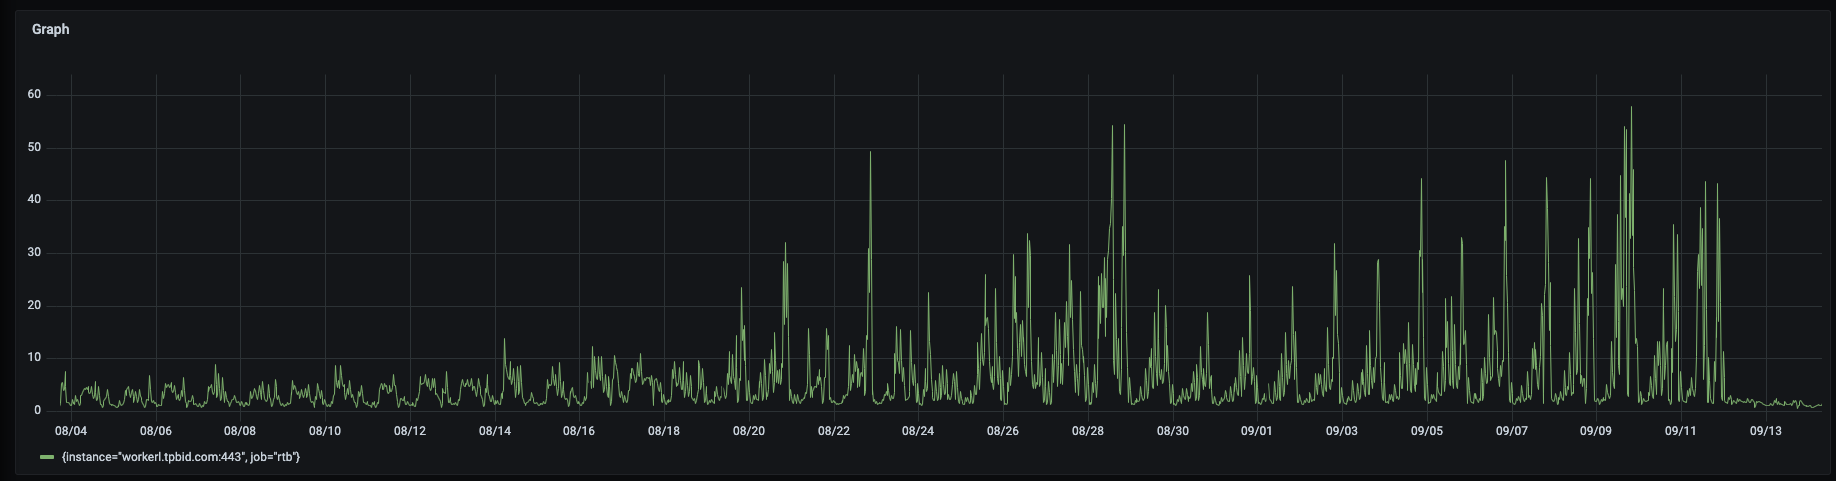

In [9]:
from IPython.display import Image
Image("files/Screen Shot 2021-09-14 at 1.27.00 PM.png")

In [46]:
b_counts = ['model','exploration_uuid','ssb_campaign_uuid','hosting_app_id','name','ssb_creative_uuid']
u_pivot = df_auctions_bids[df_auctions_bids.bids>0].pivot_table(values = b_counts, index = 'date', aggfunc = lambda x:len(x.unique()))
cnt_pivot = df_auctions_bids.pivot_table(values = ['bid_requests','bids'], index = 'date', aggfunc = np.sum)
cnt_pivot2 = df_stats.pivot_table(values = ['impressions','clicks','installs','revenue','cost'], index = 'edate', aggfunc = np.sum)
cnt_pivot = cnt_pivot.join(cnt_pivot2)

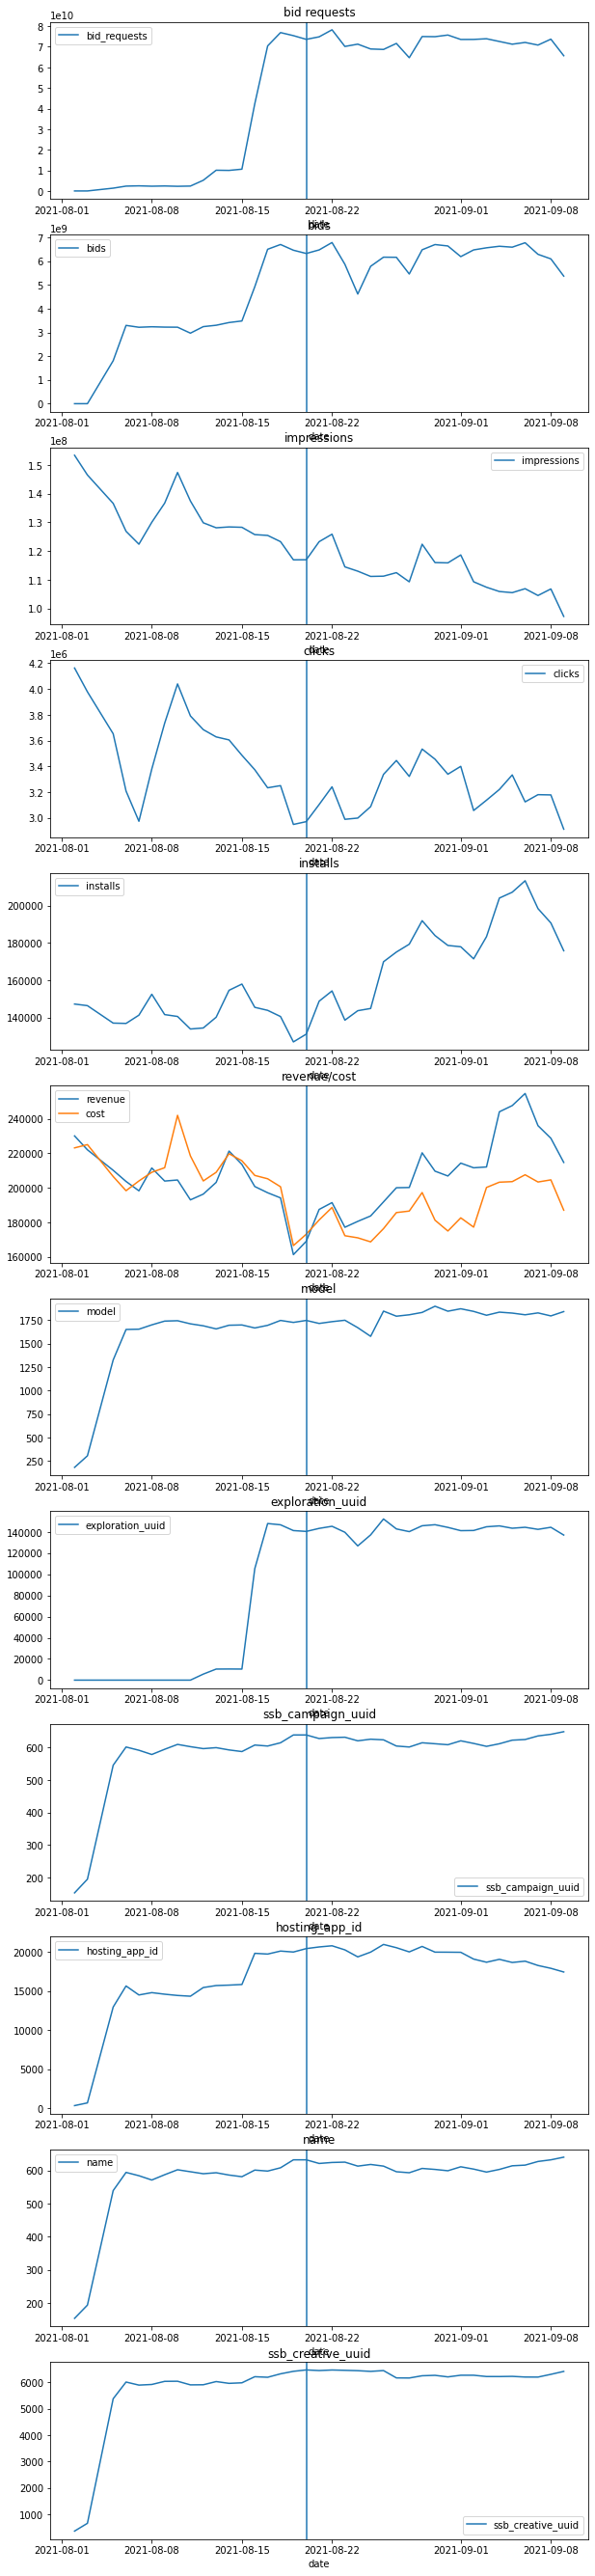

In [47]:
fig, ax = plt.subplots(len(b_counts)+6, 1, figsize = (10, 4*(len(b_counts)+6)))
cnt_pivot[['bid_requests']].plot(ax = ax[0])
ax[0].set_title('bid requests')
ax[0].axvline(x = pd.to_datetime(change_dt))
cnt_pivot[['bids']].plot(ax = ax[1])
ax[1].set_title('bids')
ax[1].axvline(x = pd.to_datetime(change_dt))
cnt_pivot[['impressions']].plot(ax = ax[2])
ax[2].set_title('impressions')
ax[2].axvline(x = pd.to_datetime(change_dt))
cnt_pivot[['clicks']].plot(ax = ax[3])
ax[3].set_title('clicks')
ax[3].axvline(x = pd.to_datetime(change_dt))
cnt_pivot[['installs']].plot(ax = ax[4])
ax[4].set_title('installs')
ax[4].axvline(x = pd.to_datetime(change_dt))
cnt_pivot[['revenue','cost']].plot(ax = ax[5])
ax[5].set_title('revenue/cost')
ax[5].legend(['revenue','cost'])
ax[5].axvline(x = pd.to_datetime(change_dt))


for b in range(len(b_counts)):
    u_pivot[[b_counts[b]]].plot(ax = ax[b+6])
    ax[b+6].set_title(b_counts[b])
    ax[b+6].axvline(x = pd.to_datetime(change_dt))

Bid requests first

<AxesSubplot:xlabel='date'>

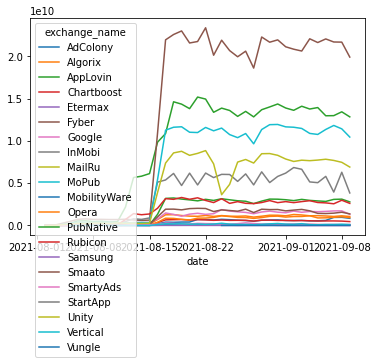

In [22]:
df_auctions_bids.pivot_table(values = 'bid_requests', columns = 'exchange_name', index = 'date', aggfunc = np.sum).plot()

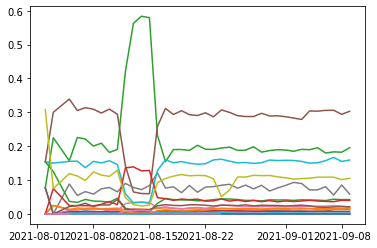

In [38]:
pivot = df_auctions_bids.pivot_table(values = 'bid_requests', columns = 'exchange_name', index = 'date', aggfunc = np.sum, margins = True)
sov_pivot = pivot.div(pivot.iloc[:,-1], axis = 0).iloc[:-1, :-1]
plt.plot(sov_pivot)